# MLP2 Data Preprocessing and Exploratory Data Analysis
## Authors: Mia Rodgers and Alex Larsen

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pool
import librosa
from os import listdir, path
from scipy import stats
# from joblib import Parallel, delayed
from os.path import isfile, join
from pathlib import Path
from matplotlib import pyplot as plt
from pandarallel import pandarallel
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## GTZAN Dataset

used this link to get all filenames 
https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

In [2]:
genre_folder = '../rawdata/genres' 
genre_names = [f for f in listdir(path=genre_folder) if not isfile(join(genre_folder, f))] 

creating dict of genres and one random song in the file (for some reason `listdir(...)[0]` does not give the first file)

In [3]:
song_list = []
for g in genre_names:
    p = genre_folder + '/' + g # path for a genre folder
    for song in sorted(listdir(path=p)): # song at index 0 for each folder
        song_path = p+'/'+song
        time_series, sample_rate = librosa.load(Path(song_path))
        song_list.append([song_path, time_series, sample_rate, g])
        

In [4]:
song_df = pd.DataFrame(song_list, columns=['song_file', 'time_series', 'sample_rate', 'genre'])
song_df

,song_file,time_series,sample_rate,genre
0,../rawdata/genres/pop/pop.00000.wav,"[-0.0887146, -0.09524536, -0.102752686, -0.113...",22050,pop
1,../rawdata/genres/pop/pop.00001.wav,"[0.7692261, 0.2246399, 0.69036865, 0.7468872, ...",22050,pop
2,../rawdata/genres/pop/pop.00002.wav,"[-0.09274292, -0.11630249, -0.11886597, -0.107...",22050,pop
3,../rawdata/genres/pop/pop.00003.wav,"[-0.024993896, -0.018157959, -0.020233154, 0.0...",22050,pop
4,../rawdata/genres/pop/pop.00004.wav,"[-0.12844849, -0.10952759, -0.06726074, -0.028...",22050,pop
...,...,...,...,...
995,../rawdata/genres/jazz/jazz.00095.wav,"[-0.062194824, -0.09188843, -0.072052, -0.0799...",22050,jazz
996,../rawdata/genres/jazz/jazz.00096.wav,"[0.045013428, 0.07720947, 0.058258057, 0.06036...",22050,jazz
997,../rawdata/genres/jazz/jazz.00097.wav,"[0.02279663, 0.03564453, 0.029205322, 0.029632...",22050,jazz
998,../rawdata/genres/jazz/jazz.00098.wav,"[-0.031066895, -0.05078125, -0.04537964, -0.04...",22050,jazz


## Feature Extraction

Features to extract:
- BPM
- Zero-Crossing Rate (rate of sign changes from positive to negative)
- Spectral Centroid (weighted mean of frequencies present in the song)
- Spectral Rolloff (measures of shape of the signal, models human voice characteristics)
- Mel-Frequency Cepstral Coefficients (measures shape of spectral envelope)
- Chroma Frequencies (measure of frequencies of different pitches, separated into 12 bins)
- Intensity: loudness in dB (relative to max possible loudness)

In [5]:
# Extract the bpm
song_df['bpm'] = song_df['time_series'].parallel_apply(lambda x: librosa.beat.tempo(y=x)[0])

# Extract the zero crossing rate
song_df['zero_crossing_rate'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.zero_crossing_rate(y= x)[0])

# Extract the spectral centroid
song_df['spectral_centroid'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.spectral_centroid(y= x)[0])

# Extract the spectral rolloff
song_df['spectral_rolloff'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.spectral_rolloff(y= x)[0])

# Extract the mel-frequency cepstral coefficients
song_df['mfcc'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.mfcc(y= x)[0])

# Extract the chroma frequencies
song_df['chroma_frequencies'] = song_df['time_series'].parallel_apply(lambda x: librosa.feature.chroma_stft(y= x)[0])

song_df

,song_file,time_series,sample_rate,genre,bpm,zero_crossing_rate,spectral_centroid,spectral_rolloff,mfcc,chroma_frequencies
0,../rawdata/genres/pop/pop.00000.wav,"[-0.0887146, -0.09524536, -0.102752686, -0.113...",22050,pop,135.999178,"[0.00927734375, 0.0234375, 0.04541015625, 0.05...","[1812.4619528427452, 2913.4550162394453, 2870....","[5415.6005859375, 8247.216796875, 8118.0175781...","[-195.25616, -150.96812, -132.99374, -149.2361...","[1.0, 1.0, 0.5475675, 0.3053872, 0.40021256, 0..."
1,../rawdata/genres/pop/pop.00001.wav,"[0.7692261, 0.2246399, 0.69036865, 0.7468872, ...",22050,pop,107.666016,"[0.02587890625, 0.03173828125, 0.03662109375, ...","[3696.826349368777, 3781.2397094717344, 3663.4...","[8268.75, 8570.21484375, 8828.61328125, 8021.1...","[8.333065, -5.5007806, -77.25962, -142.30276, ...","[0.79645, 0.5512454, 0.47261614, 0.37714073, 0..."
2,../rawdata/genres/pop/pop.00002.wav,"[-0.09274292, -0.11630249, -0.11886597, -0.107...",22050,pop,129.199219,"[0.03076171875, 0.05419921875, 0.0869140625, 0...","[2951.7610867714993, 2998.306335806811, 3043.4...","[8764.013671875, 8925.5126953125, 7913.4521484...","[-171.28282, -156.23244, -45.063564, 26.249937...","[0.29866484, 0.13757597, 0.2682937, 0.5632394,..."
3,../rawdata/genres/pop/pop.00003.wav,"[-0.024993896, -0.018157959, -0.020233154, 0.0...",22050,pop,92.285156,"[0.06689453125, 0.08251953125, 0.0908203125, 0...","[3016.556497593843, 2733.093472180655, 2394.70...","[8914.74609375, 7934.9853515625, 7418.18847656...","[-151.17372, -115.99337, -137.84445, -183.4657...","[1.0, 1.0, 0.35716882, 0.13711457, 0.09756261,..."
4,../rawdata/genres/pop/pop.00004.wav,"[-0.12844849, -0.10952759, -0.06726074, -0.028...",22050,pop,107.666016,"[0.0419921875, 0.0634765625, 0.08447265625, 0....","[1861.496524385576, 1894.3471992720065, 1987.4...","[3348.4130859375, 3348.4130859375, 3359.179687...","[-87.60696, -63.465073, -62.712914, -56.52946,...","[0.3122931, 0.39315093, 0.3674996, 0.2786543, ..."
...,...,...,...,...,...,...,...,...,...,...
995,../rawdata/genres/jazz/jazz.00095.wav,"[-0.062194824, -0.09188843, -0.072052, -0.0799...",22050,jazz,117.453835,"[0.02587890625, 0.03759765625, 0.0556640625, 0...","[1814.6794306123995, 2044.7159649785262, 2234....","[3886.7431640625, 4909.5703125, 5760.131835937...","[-211.30547, -206.57405, -231.43155, -213.8381...","[0.30835617, 0.11353422, 0.09033803, 0.1906156..."
996,../rawdata/genres/jazz/jazz.00096.wav,"[0.045013428, 0.07720947, 0.058258057, 0.06036...",22050,jazz,135.999178,"[0.044921875, 0.0673828125, 0.0859375, 0.09570...","[1955.5418442933342, 2164.7091771559126, 2369....","[4532.7392578125, 5200.2685546875, 5523.266601...","[-181.1916, -177.69016, -204.2336, -220.05225,...","[0.08535859, 0.028048158, 0.0101286825, 0.0071..."
997,../rawdata/genres/jazz/jazz.00097.wav,"[0.02279663, 0.03564453, 0.029205322, 0.029632...",22050,jazz,112.347147,"[0.017578125, 0.0263671875, 0.03564453125, 0.0...","[1187.8249264990166, 952.6527363855892, 817.10...","[2217.919921875, 1442.724609375, 1184.32617187...","[-354.09113, -373.8292, -403.8538, -416.41177,...","[0.04638605, 0.038805343, 0.03744892, 0.031752..."
998,../rawdata/genres/jazz/jazz.00098.wav,"[-0.031066895, -0.05078125, -0.04537964, -0.04...",22050,jazz,161.499023,"[0.0068359375, 0.01611328125, 0.0205078125, 0....","[1456.6106500541023, 1413.8374732896405, 1448....","[3563.7451171875, 3499.1455078125, 3574.511718...","[-308.07678, -300.8568, -313.62973, -321.6552,...","[0.9682443, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974775..."


In [6]:
corr_df = pd.DataFrame()
corr_df['genre'] = song_df['genre']
corr_df['bpm'] = song_df['bpm']
for col in song_df.columns.drop(['song_file', 'time_series', 'sample_rate', 'genre','bpm']):
    corr_df['avg_{0}'.format(col)] = song_df[col].parallel_apply(lambda x: x.mean())

corr_df.head()

,genre,bpm,avg_zero_crossing_rate,avg_spectral_centroid,avg_spectral_rolloff,avg_mfcc,avg_chroma_frequencies
0,pop,135.999178,0.126720,3422.071864,7953.037936,-94.507706,0.383527
1,pop,107.666016,0.149394,3702.062803,8072.969384,-59.167095,0.446750
2,pop,129.199219,0.118866,3214.019678,7424.267068,-59.600990,0.475822
3,pop,92.285156,0.085323,1837.492826,3671.361172,-125.878746,0.373030
4,pop,107.666016,0.123709,2753.234723,5986.838328,-20.932325,0.380148


In [7]:
from scipy import stats


for c in corr_df.columns.drop('genre'):
    F, p = stats.f_oneway(corr_df[corr_df.genre == genre_names[0]][c],
                          corr_df[corr_df.genre == genre_names[1]][c],
                          corr_df[corr_df.genre == genre_names[2]][c],
                          corr_df[corr_df.genre == genre_names[3]][c],
                          corr_df[corr_df.genre == genre_names[4]][c],
                          corr_df[corr_df.genre == genre_names[5]][c],
                          corr_df[corr_df.genre == genre_names[6]][c],
                          corr_df[corr_df.genre == genre_names[7]][c],
                          corr_df[corr_df.genre == genre_names[8]][c],
                          corr_df[corr_df.genre == genre_names[9]][c])
    print(c,F)

bpm 9.509992300744322
avg_zero_crossing_rate 58.716379580769235
avg_spectral_centroid 97.49446582239015
avg_spectral_rolloff 110.888295771945
avg_mfcc 130.37855478076267
avg_chroma_frequencies 35.1655215554282


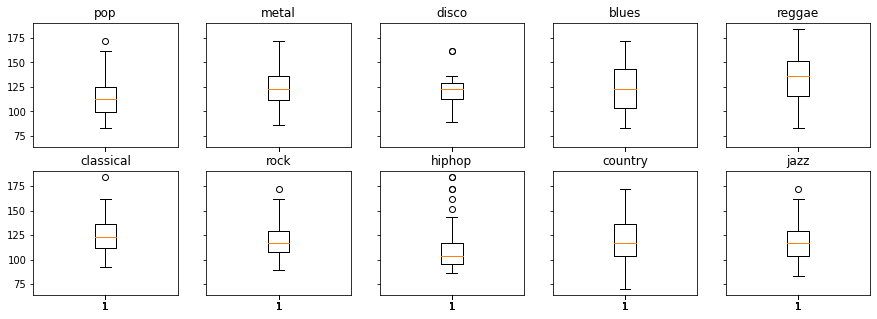

In [8]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=[15, 5])
count = 0

for g in genre_names:
    idx = (int(count/5), count % 5)
    df = song_df[song_df['genre'] == g]
    axs[idx].boxplot(df.bpm)
    axs[idx].set(title=g)
    count = count + 1

plt.show()


In [9]:
# Normalize the data
scaler = MinMaxScaler()

corr_df[['bpm', 'avg_zero_crossing_rate', 'avg_spectral_centroid', 'avg_spectral_rolloff', 'avg_mfcc', 'avg_chroma_frequencies']] = scaler.fit_transform(corr_df[['bpm', 'avg_zero_crossing_rate', 'avg_spectral_centroid', 'avg_spectral_rolloff', 'avg_mfcc', 'avg_chroma_frequencies']])

corr_df.describe()

,bpm,avg_zero_crossing_rate,avg_spectral_centroid,avg_spectral_rolloff,avg_mfcc,avg_chroma_frequencies
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.446653,0.323861,0.422090,0.482098,0.686010,0.455264
std,0.182272,0.165343,0.185212,0.198621,0.168647,0.152026
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.292174,0.191934,0.273598,0.331810,0.591308,0.352188
50%,0.415020,0.307614,0.424016,0.493016,0.726683,0.448626
75%,0.576659,0.435872,0.548713,0.603446,0.804705,0.551128
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


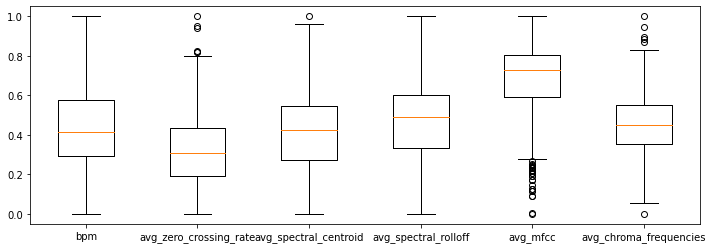

In [10]:
# Make a boxplot
song_cols = corr_df[['bpm', 'avg_zero_crossing_rate', 'avg_spectral_centroid', 'avg_spectral_rolloff', 'avg_mfcc', 'avg_chroma_frequencies']]
plt.figure(figsize=(12,4))
plt.boxplot([song_cols[column] for column in song_cols.columns], labels= [column for column in song_cols.columns])
plt.show()


In [11]:
corr_df

,genre,bpm,avg_zero_crossing_rate,avg_spectral_centroid,avg_spectral_rolloff,avg_mfcc,avg_chroma_frequencies
0,pop,0.576659,0.415220,0.737759,0.908591,0.770132,0.454706
1,pop,0.329710,0.504865,0.810195,0.923718,0.829603,0.540242
2,pop,0.517391,0.384168,0.683935,0.841894,0.828873,0.579575
3,pop,0.195652,0.251552,0.327818,0.368520,0.717341,0.440504
4,pop,0.329710,0.403314,0.564727,0.660583,0.893944,0.450134
...,...,...,...,...,...,...,...
995,jazz,0.415020,0.164729,0.332252,0.445570,0.559296,0.436090
996,jazz,0.576659,0.221480,0.337221,0.411075,0.462587,0.309047
997,jazz,0.370510,0.071998,0.156770,0.201185,0.233205,0.173162
998,jazz,0.798913,0.144046,0.340269,0.455003,0.553913,0.445306


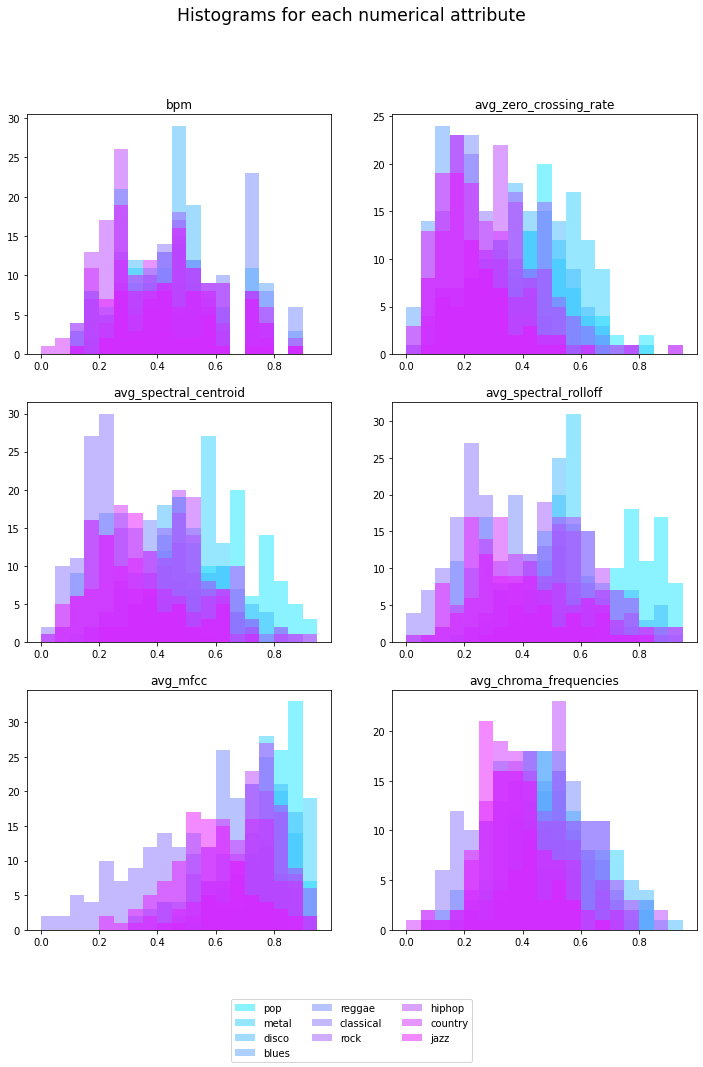

In [46]:
music_genres = corr_df.genre.unique()
numeric = corr_df[['bpm', 'avg_zero_crossing_rate', 'avg_spectral_centroid', 'avg_spectral_rolloff', 'avg_mfcc', 'avg_chroma_frequencies']]
colors = sns.color_palette('cool',10)
nrows = 2
ncols = 3
fig, axs = plt.subplots(ncols,nrows, figsize = (12, 15))
i = 0
for col in numeric:
    idx = (int(i/nrows), i%nrows)
    min = corr_df[col].min()
    max = corr_df[col].max()
    diff = max-min
    binw = [x*diff/20+min for x in range(20)]
    img = [
        axs[idx].hist(x=corr_df[corr_df['genre'] == music_genres[i]][col], 
        bins=binw, alpha=0.5, histtype='bar', 
        color = colors[i])
     for i in range(len(music_genres))]
    axs[idx].set(title = col)
    i += 1
fig.legend(labels=[corr_df[corr_df['genre'] == music_genres[i]]['genre'].iloc[0] for i in range(len(music_genres))], ncol=3, loc = 8, fontsize = 'medium', frameon=True, borderaxespad=0.5)
fig.suptitle('Histograms for each numerical attribute',size='xx-large')
plt.show()

[Text(0.5, 0, 'bpm'),
 Text(1.5, 0, 'avg_zero_crossing_rate'),
 Text(2.5, 0, 'avg_spectral_centroid'),
 Text(3.5, 0, 'avg_spectral_rolloff'),
 Text(4.5, 0, 'avg_mfcc'),
 Text(5.5, 0, 'avg_chroma_frequencies')]

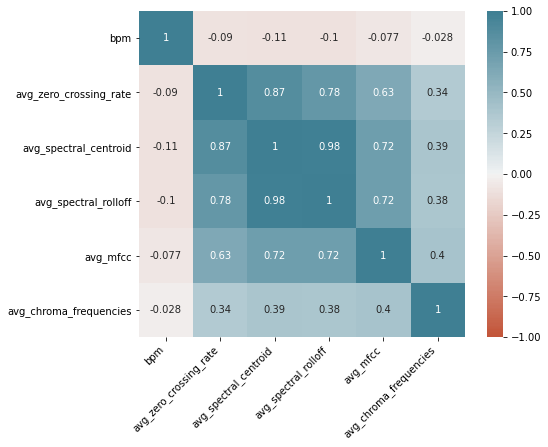

In [13]:
np.random.seed(1)

# Compute the correlation matrix
corr = corr_df.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [14]:
cs = corr_df.columns.drop(['genre'])
corrs = {}
for c in cs:
    F, p = stats.f_oneway(corr_df[corr_df.genre == music_genres[0]][c],
                          corr_df[corr_df.genre == music_genres[1]][c],
                          corr_df[corr_df.genre == music_genres[2]][c],
                          corr_df[corr_df.genre == music_genres[3]][c],
                          corr_df[corr_df.genre == music_genres[4]][c],
                          corr_df[corr_df.genre == music_genres[5]][c],
                          corr_df[corr_df.genre == music_genres[6]][c],
                          corr_df[corr_df.genre == music_genres[7]][c],
                          corr_df[corr_df.genre == music_genres[8]][c],
                          corr_df[corr_df.genre == music_genres[9]][c])
    corrs[c] = F

# The greater the F score value the higher the correlation will be.
sorted_corrs = dict(
    sorted(corrs.items(), key=lambda item: item[1], reverse=True))

print('Correlation with genre:')
for key, val in sorted_corrs.items():
    print(key, val)


Correlation with genre:
avg_mfcc 130.3785547807627
avg_spectral_rolloff 110.88829577194502
avg_spectral_centroid 97.4944658223901
avg_zero_crossing_rate 58.71637958076927
avg_chroma_frequencies 35.16552155542821
bpm 9.509992300744331


In [15]:
# Create a csv file containing the preprocessed data
song_df.to_csv('../input/audio_data.csv')
corr_df.to_csv('../input/audio_means.csv')

## CSV Dataset

### Data Preprocessing

In [16]:
# Load the data
df = pd.read_csv('../rawdata/music_genre.csv')
df.head(5) 


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [17]:
df.tail()


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.0,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.0,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.0,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.0,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop
50004,63470.0,Naughty By Nature,Hip Hop Hooray,67.0,0.10200,0.862,267267.0,0.642,0.0,F#,0.272,-13.652,Minor,0.1010,99.20100000000001,4-Apr,0.765,Hip-Hop


In [18]:
df = df.drop(columns='obtained_date')


In [19]:
df.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,0.161637,6.162990,0.101373,0.247119
min,20002.000000,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.009670,-47.046000,0.022300,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,0.992000


In [20]:
# Find null data
print(df.isnull().sum())

instance_id         5
artist_name         5
track_name          5
popularity          5
acousticness        5
danceability        5
duration_ms         5
energy              5
instrumentalness    5
key                 5
liveness            5
loudness            5
mode                5
speechiness         5
tempo               5
valence             5
music_genre         5
dtype: int64


In [21]:
# Drop the 5 rows of null data
df.dropna(inplace=True)


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 
 15  valence           50000 non-null  float64
 16  music_genre       50000 non-null  object

In [23]:
# Print tracks with an unknown duration and tempo
df[df['duration_ms'] < 0][['instance_id', 'artist_name', 'track_name', 'duration_ms', 'tempo']]


,instance_id,artist_name,track_name,duration_ms,tempo
0,32894.0,Röyksopp,Röyksopp's Night Out,-1.0,100.889
13,62039.0,DJ Shadow,Broken Levee Blues,-1.0,154.745
16,83926.0,San Holo,One Thing,-1.0,151.756
24,40033.0,The Prodigy,Diesel Power,-1.0,105.919
35,27048.0,Fabian Mazur,If U Wanted To,-1.0,?
...,...,...,...,...,...
49956,37037.0,empty_field,What You Like (feat. Ty Dolla $ign & Wiz Khalifa),-1.0,140.005
49969,61010.0,Bone Thugs-N-Harmony,No Surrender,-1.0,85.963
49979,29598.0,Young Dolph,Thinking Out Loud,-1.0,140.101
49981,90232.0,Mac Miller,Party On Fifth Ave.,-1.0,97.101


In [24]:
# Mark non-numeric values as missing or NaN
df['duration_ms'] = df['duration_ms'].replace(-1, np.NaN)
df['duration_ms'] = pd.to_numeric(df['duration_ms'], errors='coerce')
# df['tempo'] = df['tempo'].replace('?', np.NaN)
df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')

# We expect an empty dataframe here, as the values have been nulled out
df[df['duration_ms'] < 0][['instance_id', 'artist_name', 'track_name', 'duration_ms', 'tempo']].count()

instance_id    0
artist_name    0
track_name     0
duration_ms    0
tempo          0
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       45061 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             45020 non-null  float64
 15  valence           50000 non-null  float64
 16  music_genre       50000 non-null  object

In [26]:
# Find null data
print(df.isnull().sum())

instance_id            0
artist_name            0
track_name             0
popularity             0
acousticness           0
danceability           0
duration_ms         4939
energy                 0
instrumentalness       0
key                    0
liveness               0
loudness               0
mode                   0
speechiness            0
tempo               4980
valence                0
music_genre            0
dtype: int64


We will experiment with 2 options here: dropping rows with missing values, and replacing rows with missing values with the mean.

In [27]:
# Drop rows with missing values
dropped = df.copy()

dropped.dropna(inplace=True)


In [28]:
# Fill missing values with mean columnn values
numeric_columns = ['popularity', 'duration_ms', 'loudness', 'tempo']
mean_filled = df.copy()
# mean_filled['duration_ms'] = pd.to_numeric(
#     mean_filled['duration_ms'])

mean_filled = mean_filled.groupby('music_genre').transform(lambda x: x.fillna(x.mean()))


### Exploratory Data Analysis

In [29]:
# Get the five-number summary for each field
df.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,4.506100e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,45020.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.455035e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,119.952961,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.114333e+05,0.264559,0.325409,0.161637,6.162990,0.101373,30.641701,0.247119
min,20002.000000,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.904670e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,94.941500,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.273600e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,119.879000,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.756800e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,140.471250,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


In [30]:
# Get the five-number summary for each field of dropped
dropped.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,40560.000000,40560.000000,40560.000000,40560.000000,4.056000e+04,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000
mean,55874.826430,44.276677,0.305974,0.558418,2.454895e+05,0.600330,0.181603,0.193820,-9.126369,0.093738,119.874523,0.456921
std,20731.018576,15.545617,0.341108,0.178652,1.101214e+05,0.264501,0.325710,0.161501,6.154679,0.101502,30.653215,0.246942
min,20002.000000,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,37994.750000,34.000000,0.020000,0.442000,1.904800e+05,0.433000,0.000000,0.097000,-10.843000,0.036100,94.893000,0.259000
50%,55899.500000,45.000000,0.144000,0.569000,2.275330e+05,0.644000,0.000157,0.126000,-7.277000,0.048900,119.755500,0.449000
75%,73817.500000,56.000000,0.550000,0.687000,2.757600e+05,0.817000,0.152000,0.244000,-5.174000,0.098800,140.344000,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


In [31]:
# Get the five-number summary for each field of mean_filled
mean_filled.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.455189e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,119.960388,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.061562e+05,0.264559,0.325409,0.161637,6.162990,0.101373,29.150294,0.247119
min,20002.000000,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.948750e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,96.775750,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.307057e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,120.494000,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.714400e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,139.468250,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


In [32]:
mean_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 50004
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   popularity        50000 non-null  float64
 2   acousticness      50000 non-null  float64
 3   danceability      50000 non-null  float64
 4   duration_ms       50000 non-null  float64
 5   energy            50000 non-null  float64
 6   instrumentalness  50000 non-null  float64
 7   liveness          50000 non-null  float64
 8   loudness          50000 non-null  float64
 9   speechiness       50000 non-null  float64
 10  tempo             50000 non-null  float64
 11  valence           50000 non-null  float64
dtypes: float64(12)
memory usage: 5.0 MB


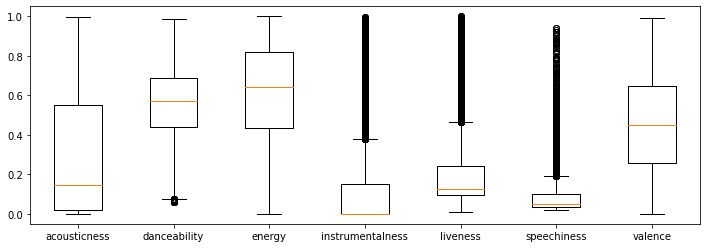

In [33]:
# Make a boxplot
cols = dropped[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

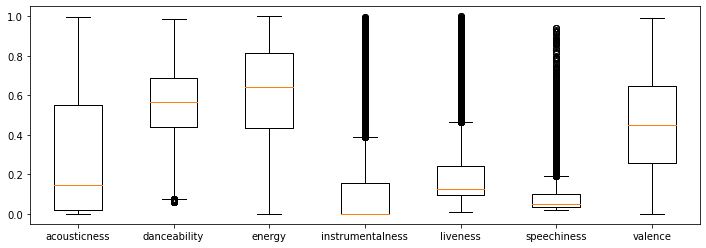

In [34]:
cols = mean_filled[['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

In [35]:
# Normalize the data
scaler = MinMaxScaler()

dropped[numeric_columns] = scaler.fit_transform(dropped[numeric_columns])

dropped.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000
mean,55874.826430,0.447239,0.305974,0.558418,0.051306,0.600330,0.181603,0.193820,0.746596,0.093738,0.460001,0.456921
std,20731.018576,0.157026,0.341108,0.178652,0.024567,0.264501,0.325710,0.161501,0.121179,0.101502,0.164865,0.246942
min,20002.000000,0.000000,0.000000,0.059600,0.000000,0.000792,0.000000,0.009670,0.000000,0.022300,0.000000,0.000000
25%,37994.750000,0.343434,0.020000,0.442000,0.039034,0.433000,0.000000,0.097000,0.712798,0.036100,0.325640,0.259000
50%,55899.500000,0.454545,0.144000,0.569000,0.047301,0.644000,0.000157,0.126000,0.783008,0.048900,0.459361,0.449000
75%,73817.500000,0.565657,0.550000,0.687000,0.058060,0.817000,0.152000,0.244000,0.824414,0.098800,0.570094,0.648000
max,91759.000000,1.000000,0.996000,0.986000,1.000000,0.999000,0.996000,1.000000,1.000000,0.942000,1.000000,0.992000


In [36]:
mean_filled.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,44.220420,0.306383,0.558241,2.455189e+05,0.599755,0.181601,0.193896,-9.133761,0.093586,119.960388,0.456264
std,20725.256253,15.542008,0.341340,0.178632,1.061562e+05,0.264559,0.325409,0.161637,6.162990,0.101373,29.150294,0.247119
min,20002.000000,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000
25%,37973.500000,34.000000,0.020000,0.442000,1.948750e+05,0.433000,0.000000,0.096900,-10.860000,0.036100,96.775750,0.257000
50%,55913.500000,45.000000,0.144000,0.568000,2.307057e+05,0.643000,0.000158,0.126000,-7.276500,0.048900,120.494000,0.448000
75%,73863.250000,56.000000,0.552000,0.687000,2.714400e+05,0.815000,0.155000,0.244000,-5.173000,0.098525,139.468250,0.648000
max,91759.000000,99.000000,0.996000,0.986000,4.830606e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000


In [37]:
# Normalize the data
scaler = MinMaxScaler()

mean_filled[numeric_columns] = scaler.fit_transform(
    mean_filled[numeric_columns])

mean_filled.describe()

,instance_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,55888.396360,0.446671,0.306383,0.558241,0.047768,0.599755,0.181601,0.193896,0.746451,0.093586,0.460463,0.456264
std,20725.256253,0.156990,0.341340,0.178632,0.022047,0.264559,0.325409,0.161637,0.121343,0.101373,0.156782,0.247119
min,20002.000000,0.000000,0.000000,0.059600,0.000000,0.000792,0.000000,0.009670,0.000000,0.022300,0.000000,0.000000
25%,37973.500000,0.343434,0.020000,0.442000,0.037251,0.433000,0.000000,0.096900,0.712463,0.036100,0.335767,0.257000
50%,55913.500000,0.454545,0.144000,0.568000,0.044692,0.643000,0.000158,0.126000,0.783018,0.048900,0.463333,0.448000
75%,73863.250000,0.565657,0.552000,0.687000,0.053152,0.815000,0.155000,0.244000,0.824434,0.098525,0.565384,0.648000
max,91759.000000,1.000000,0.996000,0.986000,1.000000,0.999000,0.996000,1.000000,1.000000,0.942000,1.000000,0.992000


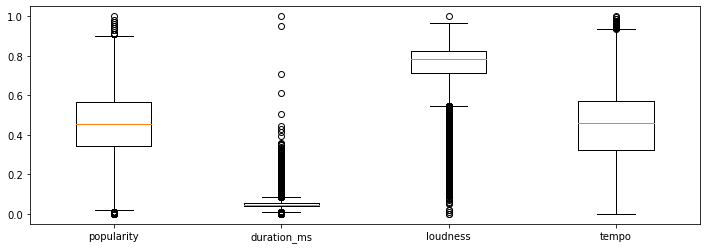

In [38]:
cols = dropped[numeric_columns]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

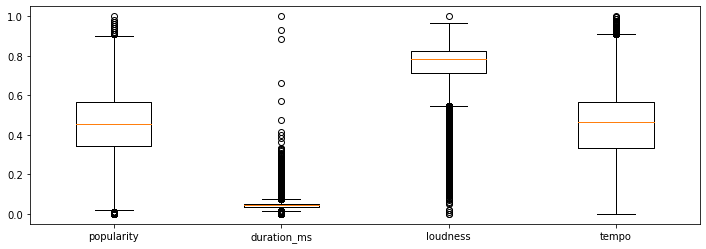

In [39]:
cols = mean_filled[numeric_columns]
plt.figure(figsize=(12,4))
plt.boxplot([cols[column] for column in cols.columns],
labels= [column for column in cols.columns])
plt.show()

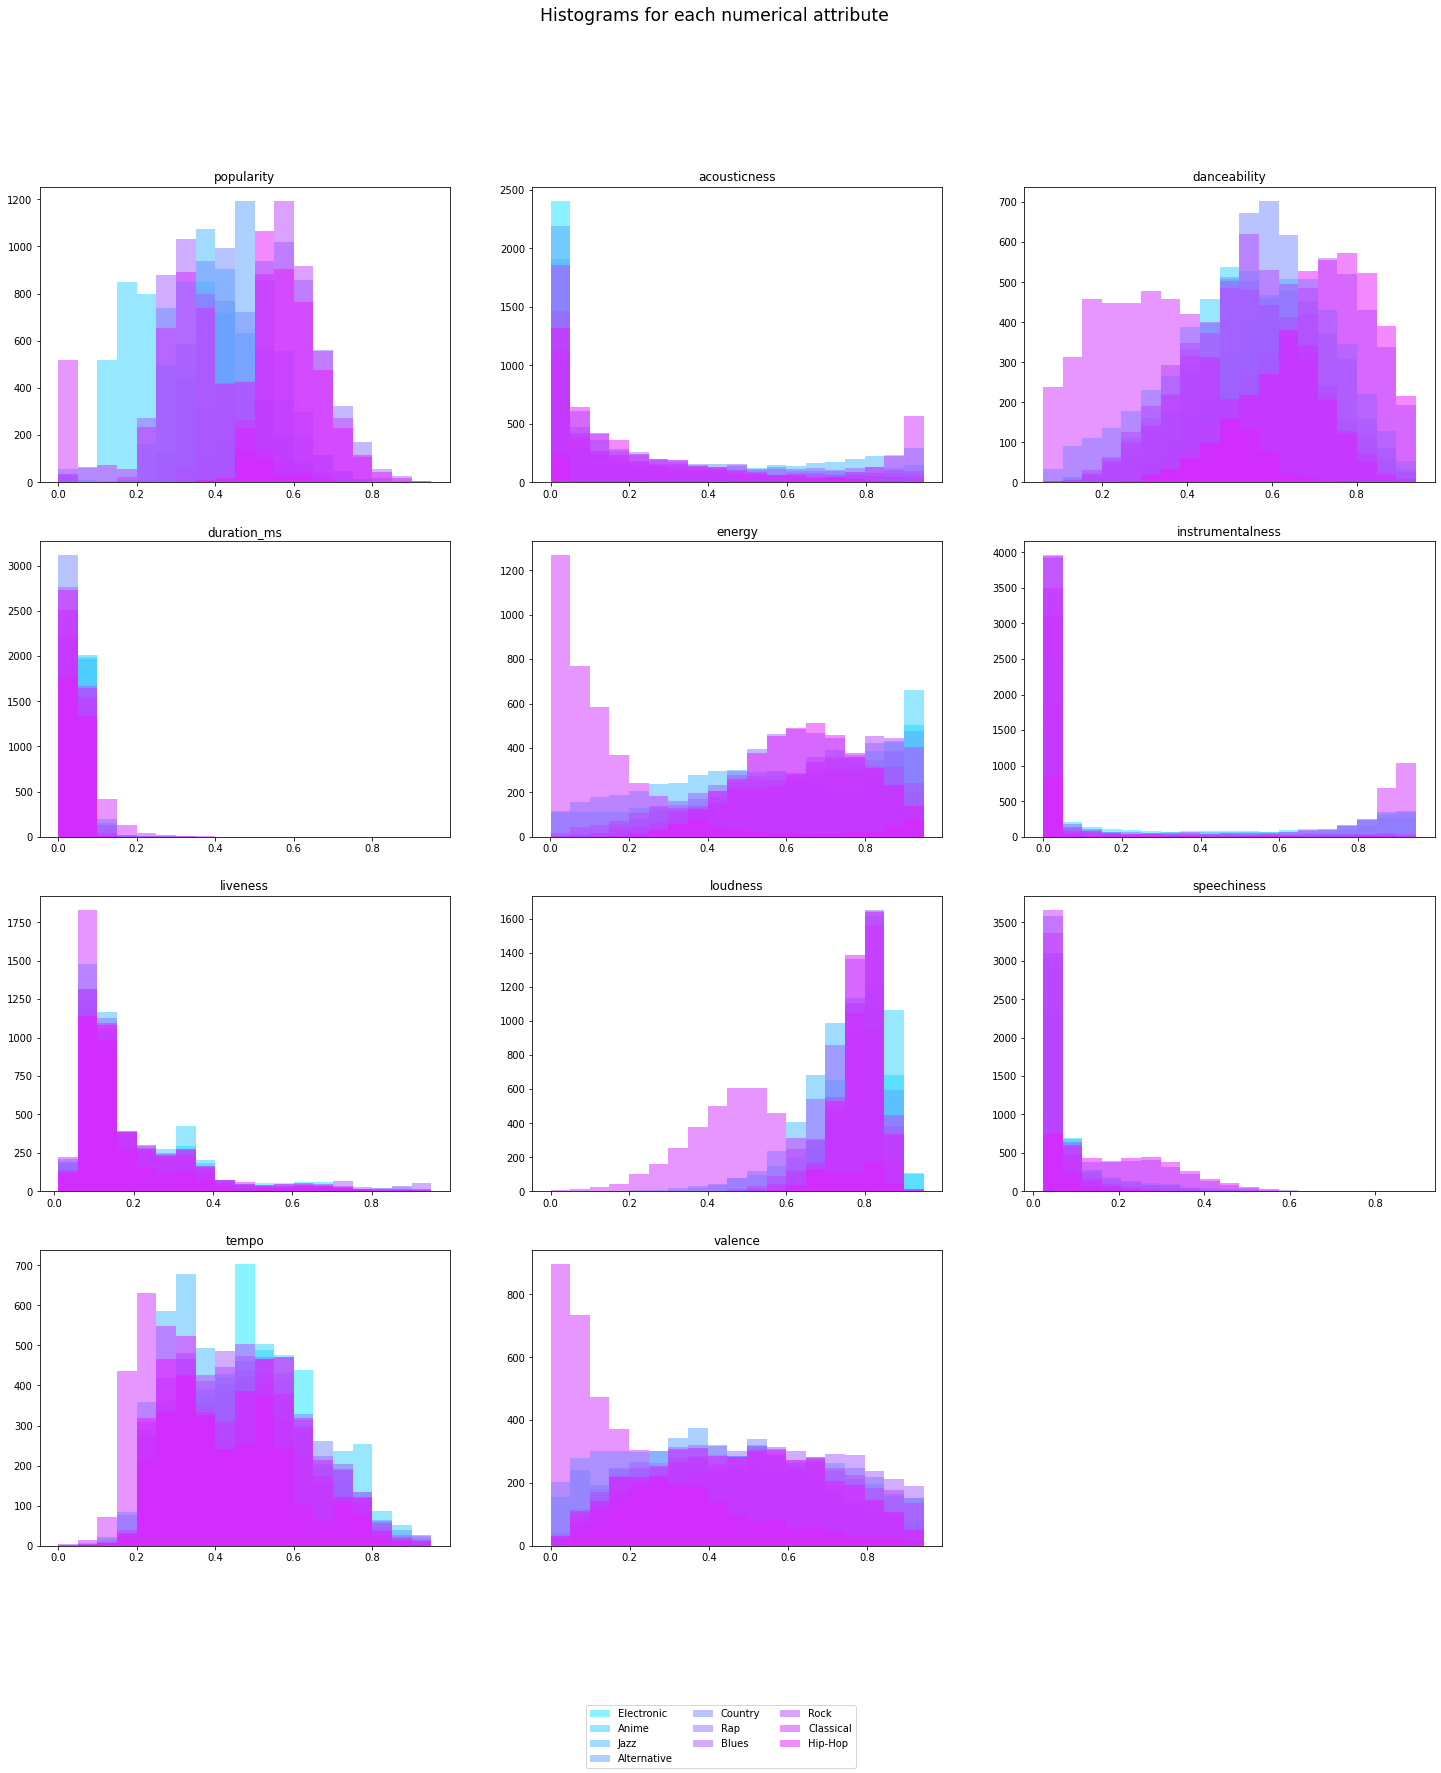

In [40]:
gs = dropped.music_genre.unique()
numeric = dropped.columns.drop(['instance_id', 'artist_name', 'track_name', 'key', 'mode', 'music_genre'])
colors = sns.color_palette('cool',10)
nrows = 3
ncols = 4
fig, axs = plt.subplots(ncols,nrows, figsize = (25,25))
i = 0
for col in numeric:
    idx = (int(i/nrows), i%nrows)
    min = dropped[col].min()
    max = dropped[col].max()
    diff = max-min
    binw = [x*diff/20+min for x in range(20)]
    img = [axs[idx].hist(x=dropped[dropped['music_genre'] == gs[i]][col], bins=binw, alpha=0.5, histtype='bar', color = colors[i])
     for i in range(len(gs))]
    axs[idx].set(title = col)
    i += 1
fig.delaxes(axs[(int(i/nrows), i%nrows)])
fig.legend(labels=[dropped[dropped['music_genre'] == gs[i]]['music_genre'].iloc[0] for i in range(len(gs))], ncol=3, loc = 8, fontsize = 'medium', frameon=True, borderaxespad=0.5)
fig.suptitle('Histograms for each numerical attribute',size='xx-large')
plt.show()

[Text(0.5, 0, 'popularity'),
 Text(1.5, 0, 'acousticness'),
 Text(2.5, 0, 'danceability'),
 Text(3.5, 0, 'duration_ms'),
 Text(4.5, 0, 'energy'),
 Text(5.5, 0, 'instrumentalness'),
 Text(6.5, 0, 'liveness'),
 Text(7.5, 0, 'loudness'),
 Text(8.5, 0, 'speechiness'),
 Text(9.5, 0, 'tempo'),
 Text(10.5, 0, 'valence')]

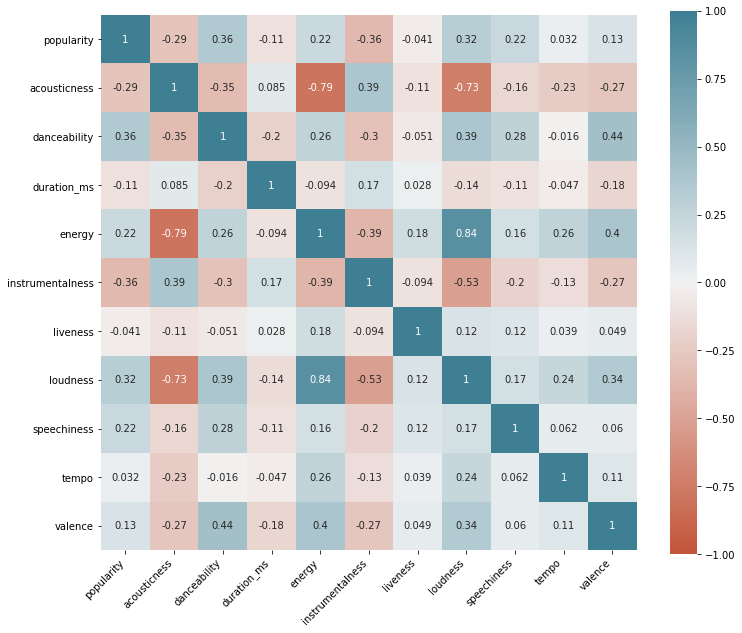

In [41]:
np.random.seed(1)

# Compute the correlation matrix
corr = dropped.drop(columns=['instance_id']).corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12,10))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


In [42]:
cs = df.columns.drop(['instance_id', 'artist_name',
                      'track_name', 'key', 'mode', 'music_genre'])
corrs = {}
for c in cs:
    F, p = stats.f_oneway(dropped[dropped.music_genre == gs[0]][c],
                          dropped[dropped.music_genre == gs[1]][c],
                          dropped[dropped.music_genre == gs[2]][c],
                          dropped[dropped.music_genre == gs[3]][c],
                          dropped[dropped.music_genre == gs[4]][c],
                          dropped[dropped.music_genre == gs[5]][c],
                          dropped[dropped.music_genre == gs[6]][c],
                          dropped[dropped.music_genre == gs[7]][c],
                          dropped[dropped.music_genre == gs[8]][c],
                          dropped[dropped.music_genre == gs[9]][c])
    corrs[c] = F

# The greater the F score value the higher the correlation will be.
sorted_corrs = dict(
    sorted(corrs.items(), key=lambda item: item[1], reverse=True))

print('Correlation with genre:')
for key, val in sorted_corrs.items():
    print(key, val)


Correlation with genre:
popularity 7388.910774000588
loudness 4555.559315438988
acousticness 2888.6088401772586
danceability 2756.5654069084253
instrumentalness 2443.8024597525455
energy 2430.8342230958933
speechiness 1780.0020558634358
valence 815.9490530984743
duration_ms 310.6960785680013
tempo 219.47072272122088
liveness 61.02393059611778


In [43]:
# Create a csv file containing the preprocessed data
dropped.to_csv('../input/dropped.csv')
mean_filled.to_csv('../input/mean_filled.csv')